# Designing a Python library for building prototypes around MinHash

This is very much work-in-progress. May be the software and or ideas presented with be the subject of a peer-reviewed or self-published write-up. For now the URL for this is: https://github.com/lgautier/mashing-pumpkins

MinHash in the context of biological sequenced was introduced by the Maryland Bioinformatics Lab [add reference here].

Building a MinHash is akin to taking a sample of all k-mers / n-grams found in a sequence and using that sample as a signature or sketch for that sequence.

## A look at convenience *vs* performance

Moving Python code to C leads to performance improvement... sometimes.

### Test sequence

First we need a test sequence. Generating a random one quickly can be achieved as follows, for example. If you already have you own way to generate a sequence, or your own benchmark sequence, the following code cell can be changed so as to end up with a variable `sequence` that is a `bytes` object containing it.

In [1]:
# we take a DNA sequence as an example, but this is arbitrary and not necessary.
alphabet = b'ATGC'
# create a lookup structure to go from byte to 4-mer
# (a arbitrary byte is a bitpacked 4-mer)
quad = [None, ]*(len(alphabet)**4)
i = 0
for b1 in alphabet:
    for b2 in alphabet:
        for b3 in alphabet:
            for b4 in alphabet:
                quad[i] = bytes((b1, b2, b3, b4))
                i += 1
# random bytes for a 3M genome (order of magnitude for a bacterial genome)
import ssl

def make_rnd_sequence(size):
  sequencebitpacked = ssl.RAND_bytes(int(size/4))
  sequence = bytearray(int(size))
  for i, b in zip(range(0, len(sequence), 4), sequencebitpacked):
      sequence[i:(i+4)] = quad[b]
  return bytes(sequence)

size = int(2E6)
sequence = make_rnd_sequence(size)

In [2]:
import time
class timedblock(object):
    def __enter__(self):
        self.tenter = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.texit = time.time()

    @property
    def duration(self):
        return self.texit - self.tenter

### Kicking the tires with `sourmash`

The executable `sourmash` is a nice package from the dib-lab implemented in Python and including a library [add reference here]. Perfect for trying out quick what MinHash sketches can do.

We will create a MinHash of maximum size 1000 (1000 elements) and of k-mer size 21 (all ngrams of length 21 across the input sequences will be considered for inclusion in the MinHash. At the time of writing MinHash is implemented in C/C++ and use that as a reference for speed, as we measure the time it takes to process our 1M reference sequence

In [3]:
from sourmash_lib._minhash import MinHash

SKETCH_SIZE = 5000
sequence_str = sequence.decode("utf-8")
with timedblock() as tb:
    smh = MinHash(SKETCH_SIZE, 21)
    smh.add_sequence(sequence_str)
t_sourmash = tb.duration
print("%.2f seconds / sequence" % t_sourmash)

0.42 seconds / sequence


This is awesome. The sketch for a bacteria-sized DNA sequence can be computed very quickly (about a second on my laptop).

### Redisigning it all for convenience and flexibility

We have redesigned what a class could look like, and implemented that design in Python
foremost for our own convenience and to match the claim of convenience. Now how bad is the impact on performance ?

Our new design allows flexibility with respect to the hash function used, and to initially illustrate our point we use `mmh` an existing Python package wrapping MurmurHash3, the hashing function used in `MASH` and `sourmash`.

In [4]:
# make a hashing function to match our design
import mmh3
def hashfun(sequence, nsize, hbuffer, w=100):
    n = min(len(hbuffer), len(sequence)-nsize+1)
    for i in range(n):
        ngram = sequence[i:(i+nsize)]
        hbuffer[i] = mmh3.hash64(ngram)[0]
    return n

from mashingpumpkins.minhashsketch import MinSketch
        
from array import array
with timedblock() as tb:
    mhs = MinSketch(21, SKETCH_SIZE, hashfun, 42)
    mhs.add(sequence, hashbuffer=array("q", [0,]*200))
    
t_basic = tb.duration
print("%.2f seconds / sequence" % (t_basic))
print("Our Python implementation is %.2f times slower." % (t_basic / t_sourmash))

0.91 seconds / sequence
Our Python implementation is 2.17 times slower.


Ah. Our Python implementation only using `mmh3` and the standard library is only a bit slower.

There is more to it though. The code in "mashingpumpkins" is doing more by keeping track of the k-mer/n-gram along with the hash value in order to allow the generation of inter-operable sketch [add reference to discussion on GitHub].

Our design in computing batches of hash values each time C is reached for MurmurHash3. We have implemented the small C function require to call MurmurHash for several k-mers, and when using it we have interesting performance gains.

In [5]:
from mashingpumpkins._murmurhash3 import hasharray
hashfun = hasharray
        
with timedblock() as tb:
    hashbuffer = array('Q', [0, ] * 300)
    mhs = MinSketch(21, SKETCH_SIZE, hashfun, 42)
    mhs.add(sequence, hashbuffer=hashbuffer)

t_batch = tb.duration

print("%.2f seconds / sequence" % (t_batch))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))


0.25 seconds / sequence
Our Python implementation is 1.68 times faster.


Wow!

At the time of writing this is between 1.5 and 2.5 times faster than C-implemented `sourmash`. And we are doing more work (we are keeping the ngrams / kmers associated with hash values).

We can modifying our class to stop storing the associated k-mer (only keep the hash value) to see if it improves performances:

However, as it was pointed out sourmash's minhash also checking that the sequenceo only uses letters from the DNA alphabet **and** computes the sketch for both the sequence and its reverse complement. We add these 2 operations (check and reverse complement) in a custom child class:

In [6]:
from mashingpumpkins._murmurhash3 import hasharray
hashfun = hasharray

from array import array

trans_tbl = bytearray(256)
for x,y in zip(b'ATGC', b'TACG'):
    trans_tbl[x] = y

def revcomp(sequence):
    ba = bytearray(sequence)
    ba.reverse()
    ba = ba.translate(trans_tbl)
    return ba
    
class MyMash(MinSketch):
    def add(self, seq, hashbuffer=array('Q', [0, ]*300)):
        ba = revcomp(sequence)
        if ba.find(0) >= 0:
            raise ValueError("Input sequence is not DNA")
        super().add(sequence, hashbuffer=hashbuffer)
        super().add(ba, hashbuffer=hashbuffer)
        
with timedblock() as tb:
    mhs = MyMash(21, SKETCH_SIZE, hashfun, 42)
    mhs.add(sequence)

t_batch = tb.duration
print("%.2f seconds / sequence" % (t_batch))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))


0.42 seconds / sequence
Our Python implementation is 1.01 times faster.


Still pretty good, the code for the check is not particularly optimal (that's the kind of primitives that would go to C).

#### MASH quirks

Unfortunately this is not quite what MASH (sourmash is based on) is doing. Tim highlighted what is happening: for every ngram and its reverse complement, the one with the lowest lexicograph order is picked for inclusion in the sketch.

Essentially, picking segment chunks depending on the lexicographic order of the chunk's direct sequence vs its reverse complement is a sampling/filtering strategy at local level before the hash value is considered for inclusion in the MinHash. The only possible reason for this could be the because the hash value is expensive to compute (but this does not seem to be the case).

Anyway, writing a slightly modified batch C function that does that extra sampling/filtering is easy and let's use conserve our design. We can then implement a MASH-like sampling in literally one line:

In [7]:
from mashingpumpkins import _murmurhash3_mash

def hashfun(sequence, nsize, buffer=array('Q', [0,]*300), seed=42):
    return _murmurhash3_mash.hasharray_withrc(sequence, revcomp(sequence), nsize, buffer, seed)

with timedblock() as tb:
    hashbuffer = array('Q', [0, ] * 300)
    mhs = MinSketch(21, SKETCH_SIZE, hashfun, 42)
    mhs.add(sequence)

t_batch = tb.duration

print("%.2f seconds / sequence" % (t_batch))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))


0.25 seconds / sequence
Our Python implementation is 1.65 times faster.


So now the claim is that we are just like sourmash/MASH, but mostly in Python and faster.

We check that the sketches are identical, and they are:

In [8]:
len(set(smh.get_mins()) ^ mhs._heapset)

0

### Parallel processing

Now what about parallel processing ?

In [9]:
from mashingpumpkins.sequence import chunkpos_iter
import ctypes
import multiprocessing
from functools import reduce
import time

NSIZE = 21
SEED = 42

def build_mhs(args):
    sketch_size, nsize, sequence = args
    mhs = MinSketch(nsize, sketch_size, hashfun, SEED)
    mhs.add(sequence)
    return mhs

res_mp = []

for l_seq in (int(x) for x in (1E6, 5E6, 1E7, 5E7)):
    sequence = make_rnd_sequence(l_seq)
    for sketch_size in (1000, 5000, 10000):
        sequence_str = sequence.decode("utf-8")
        with timedblock() as tb:
            smh = MinHash(sketch_size, 21)
            smh.add_sequence(sequence_str)
        t_sourmash = tb.duration

        with timedblock() as tb:
            ncpu = 2
            p = multiprocessing.Pool(ncpu)
            # map step (parallel in chunks)
            result = p.imap_unordered(build_mhs, 
                                      ((sketch_size, NSIZE, sequence[begin:end]) 
                                        for begin, end in chunkpos_iter(NSIZE, l_seq, l_seq//ncpu)))
            # reduce step (reducing as chunks are getting ready)
                
            mhs_mp = reduce(lambda x, y: x+y, result, next(result))
            p.terminate()
        t_pbatch = tb.duration
        res_mp.append((l_seq, t_pbatch, sketch_size, t_sourmash))

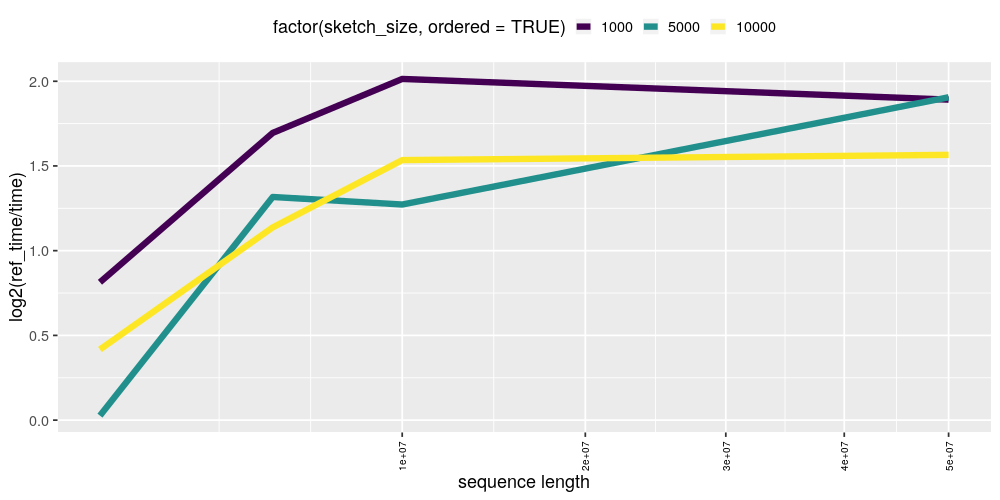

In [10]:
from rpy2.robjects.lib import dplyr, ggplot2 as ggp
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
from rpy2.robjects import Formula

dataf = dplyr.DataFrame({'l_seq': IntVector([x[0] for x in res_mp]),
                         'time': FloatVector([x[1] for x in res_mp]),
                         'sketch_size': IntVector([x[2] for x in res_mp]),
                         'ref_time': FloatVector([x[3] for x in res_mp])})

p = (ggp.ggplot(dataf) +
     ggp.geom_line(ggp.aes_string(x='l_seq', 
                                  y='log2(ref_time/time)',
                                  color='factor(sketch_size, ordered=TRUE)'),
                   size=3) +
     ggp.scale_x_sqrt("sequence length") +
     ggp.theme_gray(base_size=18) +
     ggp.theme(legend_position="top",
               axis_text_x = ggp.element_text(angle = 90, hjust = 1))
    )

import rpy2.ipython.ggplot
rpy2.ipython.ggplot.image_png(p, width=1000, height=500)

We have just made sourmash/MASH about 2 times faster... some of the times. Parallelization does not always bring speedups (depends on the size of the sketch and on the length of the sequence for which the sketch is built).

## Scaling up

Now how much time should it take to compute signature for various references ?

First we check quickly that the time is roughly proportional to the size of the reference:

In [11]:
SEED = 42

def run_sourmash(sketchsize, sequence, nsize):
    sequence_str = sequence.decode("utf-8")
    with timedblock() as tb:
        smh = MinHash(sketchsize, nsize)
        smh.add_sequence(sequence_str)
 

    return {'t': tb.duration,
            'what': 'sourmash',
            'keepngrams': False,
            'l_sequence': len(sequence),
            'bufsize': 0,
            'nsize': nsize,
            'sketchsize': sketchsize}

def run_mashingp(cls, bufsize, sketchsize, sequence, hashfun, nsize):
    hashbuffer = array('Q', [0, ] * bufsize)

    with timedblock() as tb:
        mhs = cls(nsize, sketchsize, hashfun, SEED)
        mhs.add(sequence, hashbuffer=hashbuffer)

    keepngrams = True
    return {'t': tb.duration,
            'what': 'mashingpumpkins',
            'keepngrams': keepngrams,
            'l_sequence': len(sequence),
            'bufsize': bufsize,
            'nsize': nsize,
            'sketchsize': sketchsize}

import gc
def run_mashingmp(cls, bufsize, sketchsize, sequence, hashfun, nsize):
    with timedblock() as tb:
        ncpu = 2

        p = multiprocessing.Pool(ncpu)
        l_seq = len(sequence)
        result = p.imap_unordered(build_mhs,
                                   ((sketchsize, NSIZE, sequence[begin:end]) 
                                        for begin, end in chunkpos_iter(nsize, l_seq, l_seq//ncpu))
                                 )

        # reduce step (reducing as chunks are getting ready)
        mhs_mp = reduce(lambda x, y: x+y, result, next(result))
        p.terminate()

    return {'t': tb.duration,
            'what': 'mashingpumpinks-2p',
            'keepngrams': True,
            'l_sequence': len(sequence),
            'bufsize': bufsize,
            'nsize': nsize,
            'sketchsize': sketchsize}

from ipywidgets import FloatProgress
from IPython.display import display
res = list()
bufsize = 300
seqsizes = (5E5, 1E6, 5E6, 1E7)
sketchsizes = [int(x) for x in (5E3, 1E4, 5E4, 1E5)]
f = FloatProgress(min=0, max=len(seqsizes)*len(sketchsizes)*2)
display(f)
for seqsize in (int(s) for s in seqsizes):
    env = dict()
    sequencebitpacked = ssl.RAND_bytes(int(seqsize/4))
    sequencen = bytearray(int(seqsize))
    for i, b in zip(range(0, len(sequencen), 4), sequencebitpacked):
        sequencen[i:(i+4)] = quad[b]
    sequencen = bytes(sequencen)
    for sketchsize in sketchsizes:
        for nsize in (21, 31):
            tmp = run_sourmash(sketchsize, sequencen, nsize)
            tmp.update([('hashfun', 'murmurhash3')])
            res.append(tmp)
            for funname, hashfun in (('murmurhash3', hasharray),):
                tmp = run_mashingp(MinSketch, bufsize, sketchsize, sequencen, hashfun, nsize)
                tmp.update([('hashfun', funname)])
                res.append(tmp)
                tmp = run_mashingmp(MinSketch, bufsize, sketchsize, sequencen, hashfun, nsize)
                tmp.update([('hashfun', funname)])
                res.append(tmp)
                f.value += 1

FloatProgress(value=0.0, max=32.0)

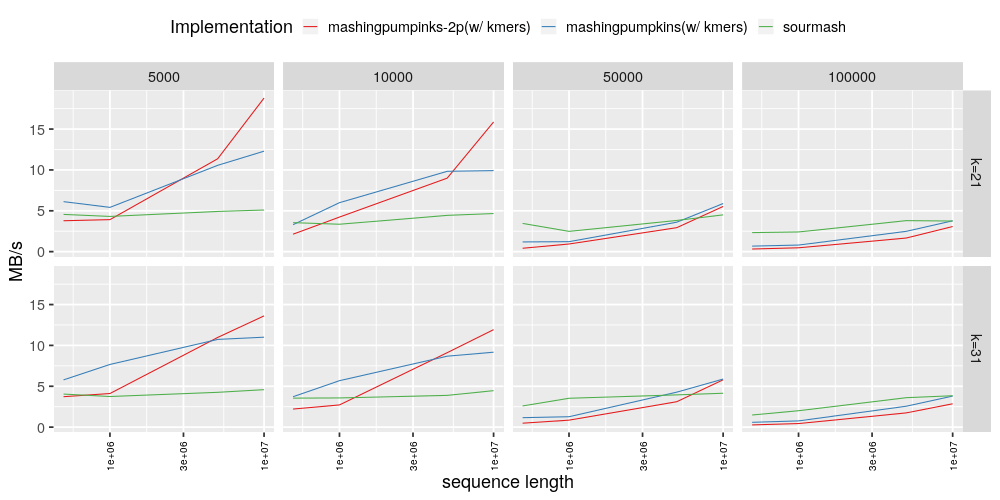

In [12]:
from rpy2.robjects.lib import dplyr, ggplot2 as ggp
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
from rpy2.robjects import Formula

d = dict((n, FloatVector([x[n] for x in res])) for n in ('t',))
d.update((n, StrVector([x[n] for x in res])) for n in ('what', 'hashfun'))
d.update((n, BoolVector([x[n] for x in res])) for n in ('keepngrams', ))
d.update((n, IntVector([x[n] for x in res])) for n in ('l_sequence', 'bufsize', 'sketchsize', 'nsize'))
dataf = dplyr.DataFrame(d)

p = (ggp.ggplot((dataf
                 .filter("hashfun != 'xxhash'")
                 .mutate(nsize='paste0("k=", nsize)',
                         implementation='paste0(what, ifelse(keepngrams, "(w/ kmers)", ""))'))) +
     ggp.geom_line(ggp.aes_string(x='l_sequence', 
                                  y='l_sequence/t/1E6', 
                                  color='implementation',
                                  group='paste(implementation, bufsize, nsize, keepngrams)'),
                   alpha=1) +
     ggp.facet_grid(Formula('nsize~sketchsize')) +
     ggp.scale_x_log10('sequence length') +
     ggp.scale_y_continuous('MB/s') +
     ggp.scale_color_brewer('Implementation', palette="Set1") +
     ggp.theme_gray(base_size=18) +
     ggp.theme(legend_position="top",
               axis_text_x = ggp.element_text(angle = 90, hjust = 1))
    )

import rpy2.ipython.ggplot
rpy2.ipython.ggplot.image_png(p, width=1000, height=500)

The rate (MB/s) with which a sequence is processed seems to strongly depend on the size of the input sequence for the `mashingpumpkins` implementation (suggesting a significant setup cost than is amortized as the sequence is getting longer), and parallelization achieve a small boost in performance (with the size of the sketch apparently counteracting that small boost). Our implementation also appears to be scaling better with increasing sequence size (relatively faster as the size is increasing).

Keeping the kmers comes with a slight cost for the larger `max_size` values (not shown). Our Python implementation is otherwise holding up quite well. XXHash appears give slightly faster processing rates in the best case, and makes no difference compared with MurmushHash3 in other cases (not shown).

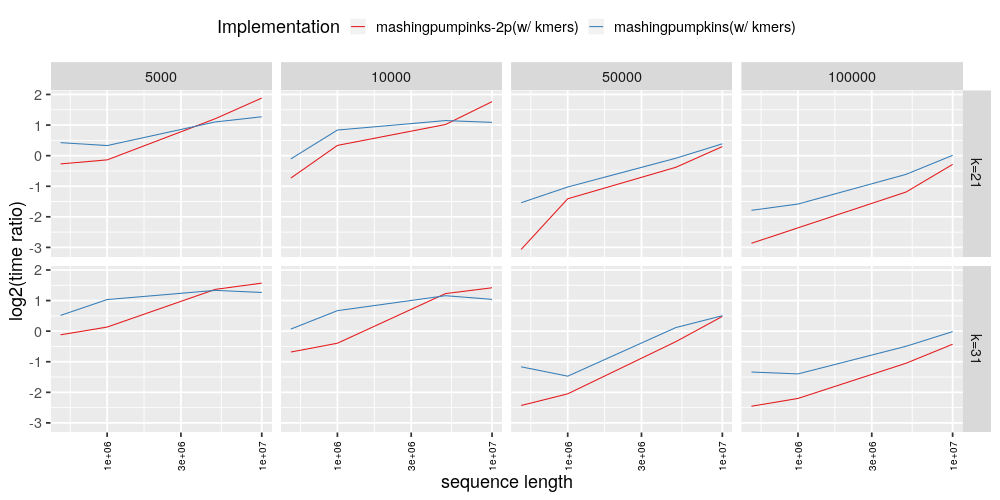

In [18]:
dataf_plot = (
    dataf
       .filter("hashfun != 'xxhash'")
       .mutate(nsize='paste0("k=", nsize)',
               implementation='paste0(what, ifelse(keepngrams, "(w/ kmers)", ""))')
)
dataf_plot2 = (dataf_plot.filter('implementation!="sourmash"')
              .inner_join(
                  dataf_plot.filter('implementation=="sourmash"')
                  .select('t', 'nsize', 'sketchsize', 'l_sequence'),
                  by=StrVector(('nsize', 'sketchsize', 'l_sequence'))))
p = (ggp.ggplot(dataf_plot2) +
     ggp.geom_line(ggp.aes_string(x='l_sequence', 
                                  y='log2(t.y/t.x)', 
                                  color='implementation',
                                  group='paste(implementation, bufsize, nsize, keepngrams)'),
                   alpha=1) +
     ggp.facet_grid(Formula('nsize~sketchsize')) +
     ggp.scale_x_log10('sequence length') +
     ggp.scale_y_continuous('log2(time ratio)') +
     ggp.scale_color_brewer('Implementation', palette="Set1") +
     ggp.theme_gray(base_size=18) +
     ggp.theme(legend_position="top",
               axis_text_x = ggp.element_text(angle = 90, hjust = 1))
    )

import rpy2.ipython.ggplot
rpy2.ipython.ggplot.image_png(p, width=1000, height=500)

One can also observe that the performance dip for the largest `max_size` value is recovering as the input sequence is getting longer. We verifiy this with a .1GB reference and `max_size` equal to 20,000.

In [14]:
seqsize = int(1E8)
print("generating sequence:")
f = FloatProgress(min=0, max=seqsize)
display(f)
sequencebitpacked = ssl.RAND_bytes(int(seqsize/4))
sequencen = bytearray(int(seqsize))
for i, b in zip(range(0, len(sequencen), 4), sequencebitpacked):
    sequencen[i:(i+4)] = quad[b]
    if i % int(1E4) == 0:
        f.value += int(1E4)
f.value = i+4
sequencen = bytes(sequencen)

generating sequence:


FloatProgress(value=0.0, max=100000000.0)

In [15]:
sketchsize = 20000
bufsize = 1000
nsize = 21
funname, hashfun = ('murmurhash3', hasharray)
tmp = run_mashingmp(MinSketch, bufsize, sketchsize, sequencen, hashfun, nsize)

In [16]:
print("%.2f seconds" % tmp['t'])
print("%.2f MB / second" % (tmp['l_sequence']/tmp['t']/1E6))

5.15 seconds
19.40 MB / second


In comparison, this is what `sourmash` manages to achieve:

In [17]:
tmp_sm = run_sourmash(sketchsize, sequencen, nsize)
print("%.2f seconds" % tmp_sm['t'])
print("%.2f MB / second" % (tmp_sm['l_sequence']/tmp_sm['t']/1E6))

20.01 seconds
5.00 MB / second


### Back-of-envelope time

Assuming 2MB bacterial genomes, and achieving the rate of 5MB/s observed for that size of reference, this would allow us to compute the 20,000-kmers signatures for 9,000 bacterial genomes per hour. On a laptop<sup>*</sup> (where this notebook was run).

(*: just a regular laptop, not a transportable workstation)

Assuming a 3GB proverbial human genome, and taking the rate we reach for a 20,000 k-mer sketch over a 500MB reference (conservative since the rate is faster as the the sequence is getting longer) this would mean a human genome processed in ~ 2 min. Not bad.

When considering raw reads from a sequencing run, this would put the 15E9 bases optimally out of a latest
Illumina MiSeq sequencer processed in under 12 mins.

I/O and parsing are not included<sup>*</sup>, but this is quite promising... and this is still in Python so customization and ideas can be implemented rather easily and quickly.

(*: this is mean to be a general Python library for MinHashing - parsing data formats is not the focus)